# [Flexible Representation of Quantum Images - FRQI](https://link.springer.com/content/pdf/10.1007/s11128-010-0177-y.pdf)

> *Le, P.Q., Dong, F. and Hirota, K. (2011)*. "A flexible representation of quantum input_vectors for polynomial preparation, input_vector compression, and processing operations". Quantum Information Processing, 10, pp.63-84. https://doi.org/10.1007/s11128-010-0177-y

Representation equation:
$$
| I(\theta)\rangle = \frac{1}{2^n}\sum_{i=0}^{2^{2n}-1}(cos\theta_i | 0 \rangle + sin\theta_i | 1 \rangle) \otimes | i \rangle
$$
where  
$\theta_i \in [0, \pi/2]$ - continuous representation of the pixel intensity (greater the value, closer to maximum intensity),  
$i$ - binary representation of the pixel coordinate.

For a $2^{n}\times2^{n}$ input_vector, circuit depth is $O(2^{4n})$ and width is $2n + 1$.  

FRQI uses the continuous amplitude encoding with intensity-to-amplitude representation. It is beneficial for the applications with limited qubit number and does not demand high intensity precision.

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, AncillaRegister, QuantumCircuit
from qiskit.quantum_info import Statevector, Operator
from qiskit_aer import Aer 
from qiskit import transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_distribution, plot_state_qsphere
import matplotlib.pyplot as plt
import numpy as np
import math

The input values are converted to angles that will be processed by the quantum circuit. These angles belong in range $[0, \pi/2]$. Numpy's interpolation methods are used for conversion, which essentially run this formula:
$$
\theta = \frac{value}{255} \times \frac{\pi}{2}
$$

[  0  85 170 255] 
 [0.         0.52359878 1.04719755 1.57079633]


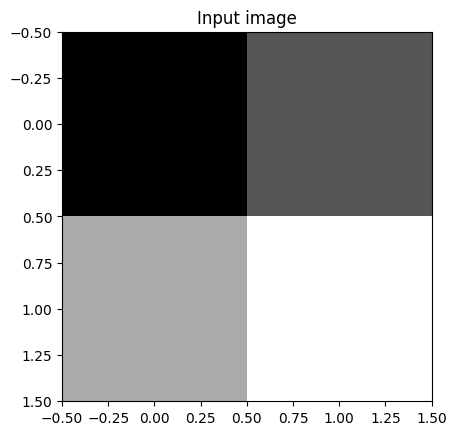

In [35]:
# INPUT
n = 4
shape = (int(math.sqrt(n)), int(math.sqrt(n)))

input_vector = np.linspace(start=0, stop=255, num=n, dtype=int)
plt.imshow(np.reshape(input_vector, shape), cmap='gray')
plt.title('Input image')

input_angles = np.interp(input_vector, (0, 255), (0, np.pi/2))
print(input_vector,"\n", input_angles)

In [36]:
# ENCODER
def frqiEncoder(qc: QuantumCircuit, angles: np.array, measure: bool = False):
    coord_q_num = int(np.ceil(math.log(len(angles), 2)))

    q = QuantumRegister(1,'q')                          # gray value
    Q = QuantumRegister(coord_q_num, 'Q')               # coords
    c = ClassicalRegister(Q.size+q.size, "c")           # measurement

    qc.add_register(q, Q, c)

    qc.id(q)
    qc.h(Q)

    controls_ = []
    for i in Q:
        controls_.append(i)

    for i, theta in enumerate(angles):
        qubit_index_bin = "{0:b}".format(i).zfill(coord_q_num)
        
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc.x(Q[k])
                
        qc.barrier()

        # for coord_or_intns in (0,1):
        qc.mcry(theta= 2*theta, q_controls=controls_, q_target=q[0])

        qc.barrier()
        
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc.x(Q[k])

    sv = Statevector(qc)
    
    if measure: qc.measure(list(reversed(range(qc.num_qubits))), list(range(c.size)))
    else: qc.barrier()

    return sv

In [37]:
# Setup basic circuit:
circuit = QuantumCircuit()
frqi_StateVec = frqiEncoder(circuit, input_angles, measure=False)

print(f"{frqi_StateVec}\n\nDepth: {circuit.depth()}, Width: {circuit.num_qubits}")
circuit.draw()

Statevector([-5.07326818e-18+0.j,  5.00000000e-01+0.j,  4.33012702e-01+0.j,
              2.50000000e-01+0.j,  2.50000000e-01+0.j,  4.33012702e-01+0.j,
              5.00000000e-01+0.j, -5.07326818e-18+0.j],
            dims=(2, 2, 2))

Depth: 22, Width: 3


┌───┐ ░ ┌───────┐┌───┐┌───────┐┌───┐ ░       ░ ┌─────────┐┌───┐»
  q: ┤ I ├─░─┤ Ry(0) ├┤ X ├┤ Ry(0) ├┤ X ├─░───────░─┤ Ry(π/6) ├┤ X ├»
     ├───┤ ░ └───────┘└─┬─┘└───────┘└─┬─┘ ░       ░ └─────────┘└─┬─┘»
Q_0: ┤ H ├─░────────────■─────────────■───░───────░──────────────■──»
     ├───┤ ░            │             │   ░ ┌───┐ ░              │  »
Q_1: ┤ H ├─░────────────■─────────────■───░─┤ X ├─░──────────────■──»
     └───┘ ░                              ░ └───┘ ░                 »
c: 3/═══════════════════════════════════════════════════════════════»
                                                                    »
«     ┌──────────┐┌───┐ ░       ░ ┌─────────┐┌───┐┌──────────┐┌───┐ ░      »
«  q: ┤ Ry(-π/6) ├┤ X ├─░───────░─┤ Ry(π/3) ├┤ X ├┤ Ry(-π/3) ├┤ X ├─░──────»
«     └──────────┘└─┬─┘ ░ ┌───┐ ░ └─────────┘└─┬─┘└──────────┘└─┬─┘ ░ ┌───┐»
«Q_0: ──────────────■───░─┤ X ├─░──────────────■────────────────■───░─┤ X ├»
«                   │   ░ ├───┤ ░              │                │   ░ ├───┤»
«Q_1: ──────────────■───░─┤ X ├─░──────────────■────────────────■───░─┤ X ├»
«                       ░ └───┘ ░                                   ░ └───┘»
«c: 3/═════════════════════════════════════════════════════════════════════»
«                                                                          »
«           ░ ┌─────────┐┌───┐┌──────────┐┌───┐ ░       ░ 
«  q: ──────░─┤ Ry(π/2) ├┤ X ├┤ Ry(-π/2) ├┤ X ├─░───────░─
«     ┌───┐ ░ └─────────┘└─┬─┘└──────────┘└─┬─┘ ░ ┌───┐ ░ 
«Q_0: ┤ X ├─░──────────────■────────────────■───░─┤ X ├─░─
«     └───┘ ░              │                │   ░ ├───┤ ░ 
«Q_1: ──────░──────────────■────────────────■───░─┤ X ├─░─
«           ░                                   ░ └───┘ ░ 
«c: 3/════════════════════════════════════════════════════
«

<IPython.core.display.Latex object>

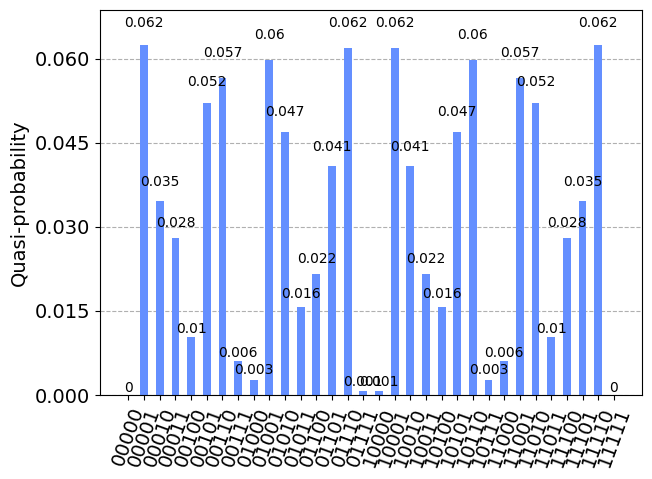

In [25]:
display(frqi_StateVec.draw('latex'))

plot_distribution(frqi_StateVec.probabilities_dict())

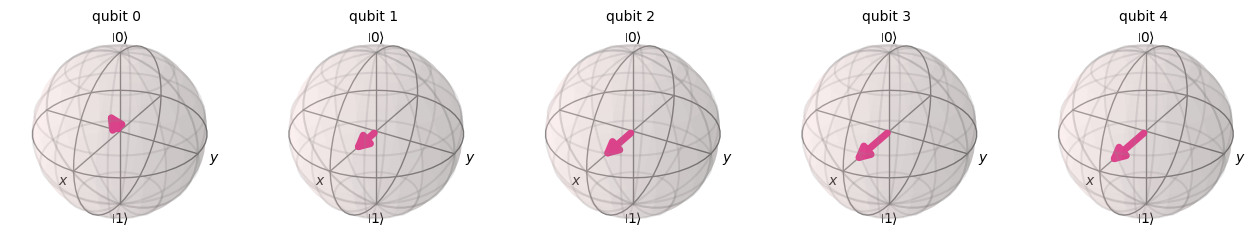

In [16]:
display(plot_bloch_multivector(frqi_StateVec))

In [39]:
# INVERTING THE PIXELS - WIP
circuit.x(circuit.qregs[0])

circuit.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(1, 'q'), 0), Qubit(QuantumRegister(2, 'Q'), 0), Qubit(QuantumRegister(2, 'Q'), 1)), clbits=())

<IPython.core.display.Latex object>

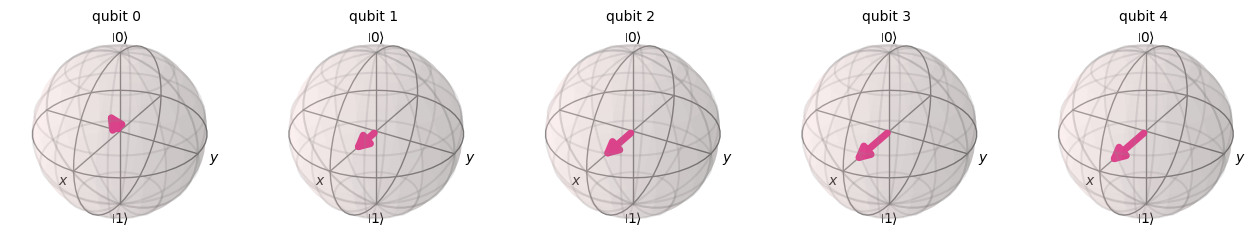

In [17]:
display(Statevector(circuit).draw('latex'))
plot_bloch_multivector(Statevector(circuit))

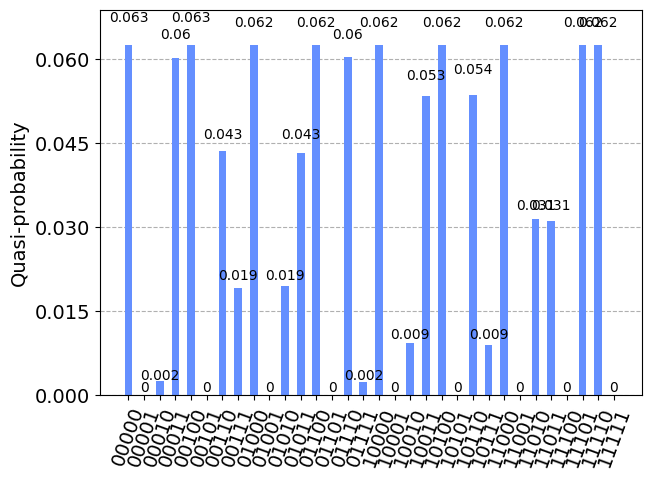

In [18]:
plot_distribution(Statevector(circuit).probabilities_dict())

In [40]:
# measurements
circuit.measure(list(reversed(range(circuit.num_qubits))), list(range(circuit.cregs[0].size)))

print(f"Depth: {circuit.depth()}, Width: {circuit.num_qubits}")
circuit.draw()

Depth: 24, Width: 3


┌───┐ ░ ┌───────┐┌───┐┌───────┐┌───┐ ░       ░ ┌─────────┐┌───┐»
  q: ┤ I ├─░─┤ Ry(0) ├┤ X ├┤ Ry(0) ├┤ X ├─░───────░─┤ Ry(π/6) ├┤ X ├»
     ├───┤ ░ └───────┘└─┬─┘└───────┘└─┬─┘ ░       ░ └─────────┘└─┬─┘»
Q_0: ┤ H ├─░────────────■─────────────■───░───────░──────────────■──»
     ├───┤ ░            │             │   ░ ┌───┐ ░              │  »
Q_1: ┤ H ├─░────────────■─────────────■───░─┤ X ├─░──────────────■──»
     └───┘ ░                              ░ └───┘ ░                 »
c: 3/═══════════════════════════════════════════════════════════════»
                                                                    »
«     ┌──────────┐┌───┐ ░       ░ ┌─────────┐┌───┐┌──────────┐┌───┐ ░      »
«  q: ┤ Ry(-π/6) ├┤ X ├─░───────░─┤ Ry(π/3) ├┤ X ├┤ Ry(-π/3) ├┤ X ├─░──────»
«     └──────────┘└─┬─┘ ░ ┌───┐ ░ └─────────┘└─┬─┘└──────────┘└─┬─┘ ░ ┌───┐»
«Q_0: ──────────────■───░─┤ X ├─░──────────────■────────────────■───░─┤ X ├»
«                   │   ░ ├───┤ ░              │                │   ░ ├───┤»
«Q_1: ──────────────■───░─┤ X ├─░──────────────■────────────────■───░─┤ X ├»
«                       ░ └───┘ ░                                   ░ └───┘»
«c: 3/═════════════════════════════════════════════════════════════════════»
«                                                                          »
«           ░ ┌─────────┐┌───┐┌──────────┐┌───┐ ░       ░ ┌───┐ ░       ┌─┐
«  q: ──────░─┤ Ry(π/2) ├┤ X ├┤ Ry(-π/2) ├┤ X ├─░───────░─┤ X ├─░───────┤M├
«     ┌───┐ ░ └─────────┘└─┬─┘└──────────┘└─┬─┘ ░ ┌───┐ ░ └───┘ ░    ┌─┐└╥┘
«Q_0: ┤ X ├─░──────────────■────────────────■───░─┤ X ├─░───────░────┤M├─╫─
«     └───┘ ░              │                │   ░ ├───┤ ░       ░ ┌─┐└╥┘ ║ 
«Q_1: ──────░──────────────■────────────────■───░─┤ X ├─░───────░─┤M├─╫──╫─
«           ░                                   ░ └───┘ ░       ░ └╥┘ ║  ║ 
«c: 3/═════════════════════════════════════════════════════════════╩══╩══╩═
«                                                                  0  1  2

C:\Users\sudha\AppData\Local\Temp\ipykernel_8828\1306491222.py:6: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = aer_sim.run(qobj)


{'111': 249530, '001': 187566, '000': 250041, '110': 187678, '101': 62201, '010': 62984}


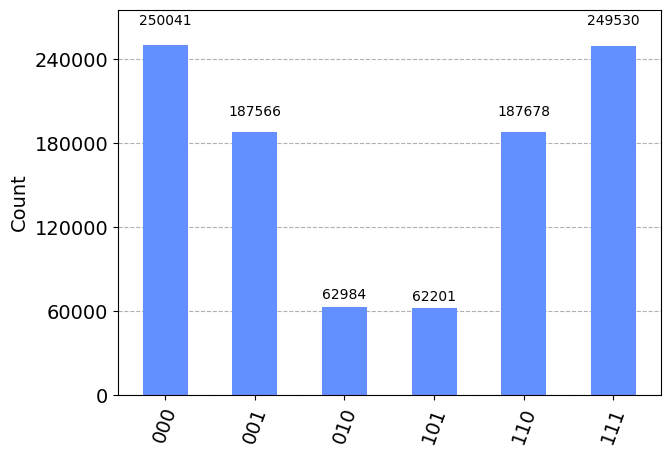

In [41]:
# SIMULATE
shots = 1000000
aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(circuit, aer_sim)
qobj = assemble(t_qc_image, shots=shots)
job = aer_sim.run(qobj)
result = job.result()
counts = result.get_counts()

print(counts)
plot_histogram(counts)

In [42]:
print(f"Depth: {t_qc_image.depth()}, Width: {t_qc_image.num_qubits}")

t_qc_image.draw()

Depth: 23, Width: 3


┌───┐ ░ ┌───────┐┌───┐┌───────┐┌───┐ ░       ░ ┌─────────┐┌───┐»
  q: ┤ I ├─░─┤ Ry(0) ├┤ X ├┤ Ry(0) ├┤ X ├─░───────░─┤ Ry(π/6) ├┤ X ├»
     ├───┤ ░ └───────┘└─┬─┘└───────┘└─┬─┘ ░       ░ └─────────┘└─┬─┘»
Q_0: ┤ H ├─░────────────■─────────────■───░───────░──────────────■──»
     ├───┤ ░            │             │   ░ ┌───┐ ░              │  »
Q_1: ┤ H ├─░────────────■─────────────■───░─┤ X ├─░──────────────■──»
     └───┘ ░                              ░ └───┘ ░                 »
c: 3/═══════════════════════════════════════════════════════════════»
                                                                    »
«     ┌──────────┐┌───┐ ░       ░ ┌─────────┐┌───┐┌──────────┐┌───┐ ░       ░ »
«  q: ┤ Ry(-π/6) ├┤ X ├─░───────░─┤ Ry(π/3) ├┤ X ├┤ Ry(-π/3) ├┤ X ├─░───────░─»
«     └──────────┘└─┬─┘ ░ ┌───┐ ░ └─────────┘└─┬─┘└──────────┘└─┬─┘ ░       ░ »
«Q_0: ──────────────■───░─┤ X ├─░──────────────■────────────────■───░───────░─»
«                   │   ░ ├───┤ ░              │                │   ░ ┌───┐ ░ »
«Q_1: ──────────────■───░─┤ X ├─░──────────────■────────────────■───░─┤ X ├─░─»
«                       ░ └───┘ ░                                   ░ └───┘ ░ »
«c: 3/════════════════════════════════════════════════════════════════════════»
«                                                                             »
«     ┌─────────┐┌───┐┌──────────┐┌───┐ ░       ░ ┌───┐ ░       ┌─┐
«  q: ┤ Ry(π/2) ├┤ X ├┤ Ry(-π/2) ├┤ X ├─░───────░─┤ X ├─░───────┤M├
«     └─────────┘└─┬─┘└──────────┘└─┬─┘ ░ ┌───┐ ░ └───┘ ░    ┌─┐└╥┘
«Q_0: ─────────────■────────────────■───░─┤ X ├─░───────░────┤M├─╫─
«                  │                │   ░ ├───┤ ░       ░ ┌─┐└╥┘ ║ 
«Q_1: ─────────────■────────────────■───░─┤ X ├─░───────░─┤M├─╫──╫─
«                                       ░ └───┘ ░       ░ └╥┘ ║  ║ 
«c: 3/═════════════════════════════════════════════════════╩══╩══╩═
«                                                          0  1  2

For decoding, we need the gray value for every pixel. Following formula is used to calculate the values:

$$
\upsilon = \arccos \left(\sqrt{\frac{P(j||0\rangle)}{P(j||0\rangle) + P(j||1\rangle)}}\right)
$$
where,  
$P(j||0\rangle)$ is the conditional probability of observing a state $j$ given that the gray value of the qubit is in state $|0\rangle$,  
Similarly, $P(j||1\rangle)$ is to probability of observing a state $j$ given that the gray value of the qubit is in state $|1\rangle$.  

This value is in radians and must be interpolated back from (0, $\pi/2$) to (0, 255).

In our case, the first qubit is associated with the gray value and the other qubits store the coordinates of that pixel.
1. For each pixel, we will iterate over every output state and check the coordinates of the state. If these coordinates match with the selected pixel, we will store the value.
2. We will iterate over the color values for that pixel, and calculate the total count, when that pixel had value '0'.
3. Use the above formula to get the exact value.
4. Interpolate back in range (0, 255).

In [30]:
# RECONSTRUCT
reconstruct = []

for i in range(len(input_vector)):
    print(f"\nFor pixel at coords {i}:")
    color_list = []                         # stores the values 

    # step 1
    for key, count in counts.items():
        int_coord = int(key[1:], 2)         # all qubits but 1st will store coordinates
        
        # if coordinates match with pixel in focus, store the gray value and count
        if int_coord == i:
            color_list.append((key[0], count))        
    print(f"\tGray value of matching states and their counts: {color_list}")

    # step 2
    zero_count = 0                          # total count for gray value = 0
    for gvalue, count in color_list:
        if not int(gvalue):                 # if gvalue == 0, get total for P(j||0>)
            zero_count = zero_count + count
    print(f"\tTotal count where gray value is 0 = P(j||0>) = {zero_count}")

    # step 3
    try:
        gvalue = np.arccos((zero_count/sum(n for _, n in color_list))**(1/2))
        reconstruct.append(gvalue)
        print(f"\tarccos(sqrt(zero_count / total_count)): {gvalue}")
    except ZeroDivisionError:
        print("\tZeroDivisionError")

# step 4 (readout is reversed as we used 1st qubit for gray value instead of the last qubit)
reconstruct = list(reversed(np.interp(reconstruct, (0, np.pi/2), (0, 255)).astype(int)))
print(f"\nOriginal values: {input_vector}\nReconstructed Inverted values: {reconstruct}")


For pixel at coords 0:
	Gray value of matching states and their counts: [('0', 62253)]
	Total count where gray value is 0 = P(j||0>) = 62253
	arccos(sqrt(zero_count / total_count)): 0.0

For pixel at coords 1:
	Gray value of matching states and their counts: [('0', 62062), ('1', 675)]
	Total count where gray value is 0 = P(j||0>) = 62062
	arccos(sqrt(zero_count / total_count)): 0.10391347783557807

For pixel at coords 2:
	Gray value of matching states and their counts: [('0', 59634), ('1', 2698)]
	Total count where gray value is 0 = P(j||0>) = 59634
	arccos(sqrt(zero_count / total_count)): 0.2095797955388721

For pixel at coords 3:
	Gray value of matching states and their counts: [('0', 56621), ('1', 5803)]
	Total count where gray value is 0 = P(j||0>) = 56621
	arccos(sqrt(zero_count / total_count)): 0.30982831497688385

For pixel at coords 4:
	Gray value of matching states and their counts: [('0', 52207), ('1', 10246)]
	Total count where gray value is 0 = P(j||0>) = 52207
	arccos(sqr

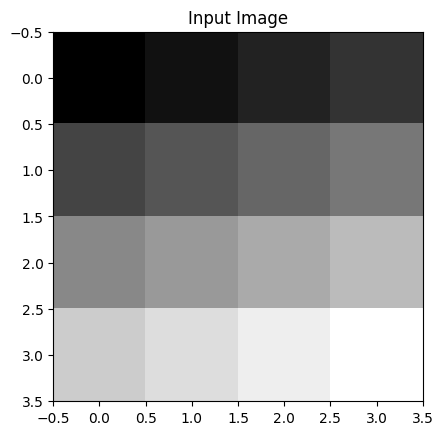

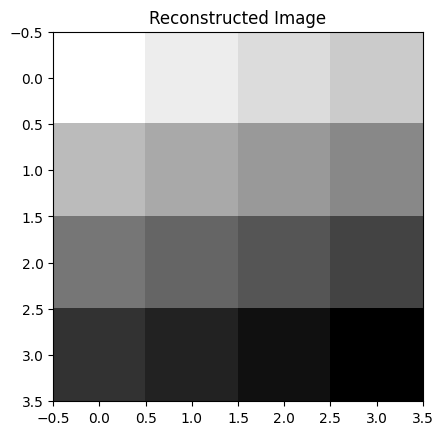

In [31]:
def plot_to_compare(input_vector, reconstruct):
    plt.imshow(np.reshape(input_vector, shape), cmap = 'gray')
    plt.title('Input Image')
    plt.show()
    plt.imshow(np.reshape(reconstruct, shape), cmap = 'gray')
    plt.title('Reconstructed Image')
    plt.show()

plot_to_compare(input_vector, reconstruct)

Detailed discussion and implementation, based on Qiskit textbook can be found [here](https://github.com/Qiskit/textbook/blob/main/notebooks/ch-applications/image-processing-frqi-neqr.ipynb) and [here](https://physlab.org/wp-content/uploads/2023/05/QImage_Rep_22120005_Fin.pdf).